The code and concept for this notebook has been taken from: https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
clean_tweets = pd.read_csv('gdrive/MyDrive/clean_tweets_sentiment.csv')

In [5]:
# Dropping Nan values from the dataframe
clean_tweets=clean_tweets.dropna().reset_index(drop=True)

In [6]:
# Extract the entity pair from the text.
def extract_entity_pairs(text):

  # All entities will be empty if nothing is found.
  entity1 = ""
  entity2 = ""

  # Keeping track of previous token and it's dependency tag. Initially everything will be empty.
  prev_token_dep = ""    
  prev_token = ""  
  prefix = ""
  modifier = ""
  
  for token in nlp(text):

    ## Check for modifiers and compound words as they will be part of the same entity.
  
    # In case of punctuation, ignore the punctuation.
    if token.dep_ != "punct":
      # Check if token is a compound word.
      if token.dep_ == "compound":
        prefix = token.text
        # If the previous word was also a 'compound' then add the current word to it
        if prev_token_dep == "compound":
          prefix = prev_token + " "+ token.text
      
      # Ckeck if token is a modifier.
      if token.dep_.endswith("mod") == True:
        modifier = token.text
        # If the previous word was also a 'compound' then add the current word to it
        if prev_token_dep == "compound":
          modifier = prev_token + " "+ token.text
      
      # Assigning object or subject to the identified entities. 
      if token.dep_.find("subj") == True:
        entity1 = modifier +" "+ prefix + " "+ token.text
        prefix = ""
        modifier = ""
        prev_token_dep = ""
        prev_token = ""      

      if token.dep_.find("obj") == True:
        entity2 = modifier +" "+ prefix +" "+ token.text
 
      # Updating the variables for next iteration.
      prev_token_dep = token.dep_
      prv_tok_text = token.text

  return [entity1.strip(), entity2.strip()]

In [7]:
entity_pairs = []

# Extracting the entity pairs of source and target.
for i in tqdm(clean_tweets["Clean_Tweets"][:1300000]):
  entity_pairs.append(extract_entity_pairs(i))

In [10]:
# Extract the relation between entities by finding the ROOT of the sentence. 
def extract_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  # ROOT can be followed by preposition phrases or adjective phrases. Defining the pattern for it.
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)

  # In case nothing matches, relation will be an empty string. These cases can then be dropped from the dataset.
  if len(matches) == 0:
    return(' ')
  
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [11]:
# Extracting relation between source and target.
relations = [extract_relation(i) for i in tqdm(clean_tweets['Clean_Tweets'][:1300000])]

In [ ]:
# Get the source
source = [i[0] for i in entity_pairs]

# Get the target
target = [i[1] for i in entity_pairs]

# Define the Dataframe for Knowledge Graph 
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [13]:
# Dropping Nan values again, as some source, target or relation might be empty strings.
kg_df=kg_df.dropna().reset_index(drop=True)

In [14]:
# Printing the top 50 relations based on count.
pd.Series(kg_df['edge']).value_counts()[:50]

have       28858
is         24599
's         15868
miss       14605
want       13382
think      12329
love       11944
got        11245
'm         10839
need        9769
wish        9556
get         8616
know        8506
was         8414
hope        7745
had         7651
going       7315
be          6801
hate        6542
are         6253
see         5595
like        5182
gon         5112
do          4954
go          4485
am          3743
feel        3663
make        3580
guess       3534
m           3339
missed      3262
let         3180
lol         3138
has         2991
wait        2925
Hope        2595
makes       2568
been        2503
made        2458
find        2415
thought     2371
take        2309
come        2242
lost        2221
help        2167
say         2161
believe     2120
tell        2105
wanted      2024
haha        2002
Name: edge, dtype: int64

In [31]:
# Extracting the source and target for specific relations.
believe_df = kg_df.loc[kg_df['edge'] == 'believe']

In [33]:
missed_df = kg_df.loc[kg_df['edge'] == 'missed']

In [16]:
love_df = kg_df.loc[kg_df['edge'] == 'love']

In [17]:
hate_df = kg_df.loc[kg_df['edge'] == 'hate']

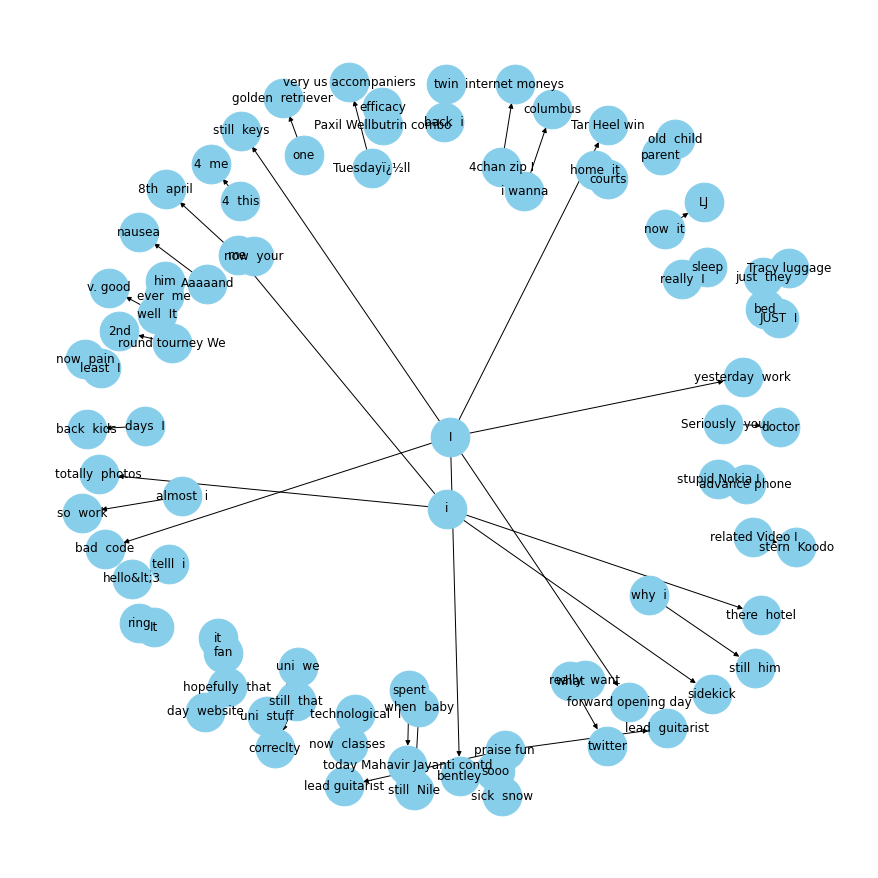

In [35]:
# Plotting the relation specific knowledge graphs. 
G=nx.from_pandas_edgelist(kg_df[150:200], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500)
plt.show()
plt.savefig("gdrive/MyDrive/kg_full_df.png")